In [1]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
                                  
    # 2016 (case 7) (동해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12) (서해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4) (남해)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
#     dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 동해 서해 남해 
        if i <8:
            only_train_dataset[i]['E'] = 0
            only_train_dataset[i]['W'] = 0
            only_train_dataset[i]['S'] = 1
        else:
            only_train_dataset[i]['E'] = 0
            only_train_dataset[i]['W'] = 1
            only_train_dataset[i]['S'] = 0
        
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # 'diff_wind_x'열 생성
        only_train_dataset[i]['diff_wind_x'] = only_train_dataset[i]['wind_x'].diff() 
        only_train_dataset[i]['diff_wind_x'][0] = 0
        # 'diff_wind_y'열 생성
        only_train_dataset[i]['diff_wind_y'] = only_train_dataset[i]['wind_y'].diff()
        only_train_dataset[i]['diff_wind_y'][0] = 0
        # 'diff_wind_x'열 생성
        only_train_dataset[i]['diff_water_velocity_x'] = only_train_dataset[i]['water_velocity_x'].diff() 
        only_train_dataset[i]['diff_water_velocity_x'][0] = 0
        # 'diff_wind_y'열 생성
        only_train_dataset[i]['diff_water_velocity_y'] = only_train_dataset[i]['water_velocity_y'].diff() 
        only_train_dataset[i]['diff_water_velocity_y'][0] = 0
        # 초기 이동 고려 (원-핫 인코딩)
        only_train_dataset[i]['initial'] = 0
        only_train_dataset[i]['not_initial'] = 0
        for j in range(0,10):
            only_train_dataset[i]['not_initial'][j] = 0
            only_train_dataset[i]['initial'][j] = 1
        
        # model_x2_lon
        # diff_lon열 생성
        only_train_dataset[i]['diff_mod_lon'] = only_train_dataset[i]['model_x2_lon'].diff() 
        only_train_dataset[i]['diff_mod_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_mod_lat'] = only_train_dataset[i]['model_x2_lat'].diff()
        only_train_dataset[i]['diff_mod_lat'][0] = 0
        
        only_train_dataset[i]['water_velocity_x_10'] = only_train_dataset[i]['water_velocity_x'] * 10
        only_train_dataset[i]['water_velocity_y_10'] = only_train_dataset[i]['water_velocity_y'] * 10
        
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        only_train_dataset[i]['diff'] = only_train_dataset[i]['diff']
        
        # Null 값 제외
        
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    
        df = only_train_dataset[i]
        indices = df.query('wind_x < -90 or wind_y < -90 or water_velocity_x < -90 or water_velocity_y < -90').index
        df.drop(indices, inplace=True)
        df.reset_index(drop = True, inplace=True)
        only_train_dataset[i] = df 
        
     # 기상청 데이터 전처리 
    for i in range(len(dataset)):
        # 동해 서해 남해 
        if i <7:
            dataset[i]['E'] = 1
            dataset[i]['W'] = 0
            dataset[i]['S'] = 0
        elif i >= 7 and i<18:
            dataset[i]['E'] = 0
            dataset[i]['W'] = 1
            dataset[i]['S'] = 0
        else:
            dataset[i]['E'] = 0
            dataset[i]['W'] = 0
            dataset[i]['S'] = 1
        
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # 'diff_wind_x'열 생성
        dataset[i]['diff_wind_x'] = dataset[i]['wind_x'].diff() 
        dataset[i]['diff_wind_x'][0] = 0
        # 'diff_wind_y'열 생성
        dataset[i]['diff_wind_y'] = dataset[i]['wind_y'].diff()
        dataset[i]['diff_wind_y'][0] = 0
        # 'diff_wind_x'열 생성
        dataset[i]['diff_water_velocity_x'] = dataset[i]['water_velocity_x'].diff() 
        dataset[i]['diff_water_velocity_x'][0] = 0
        # 'diff_wind_y'열 생성
        dataset[i]['diff_water_velocity_y'] = dataset[i]['water_velocity_y'].diff() 
        dataset[i]['diff_water_velocity_y'][0] = 0
        
        # 초기 이동 고려 (원-핫 인코딩)
        dataset[i]['initial'] = 0
        dataset[i]['not_initial'] = 1
        for j in range(0,30):
            dataset[i]['not_initial'][j] = 0
            dataset[i]['initial'][j] = 1
        
        dataset[i]['diff_mod_lon'] = dataset[i]['model_x2_lon'].diff() 
        dataset[i]['diff_mod_lon'][0] = 0
        
        # diff_lat열 생성
        dataset[i]['diff_mod_lat'] = dataset[i]['model_x2_lat'].diff()
        dataset[i]['diff_mod_lat'][0] = 0
        
        # mod diff 
        dataset[i]['diff_mod'] = (dataset[i]['diff_mod_lon']**2 + dataset[i]['diff_mod_lat']**2)**(1/2)
        
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        
        # Null 값 제외
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled

In [2]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:130: SettingWithCopyW

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_mod_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\3953088137.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

In [4]:
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          Dense(units = latent_dim, input_dim = 7, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          Dense(7, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/150


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['diff_mod'][0] = diff_mod


93/93 [==============================] - 0s 929us/step - loss: 6.9729
Epoch 2/150
93/93 [==============================] - 0s 919us/step - loss: 6.2169
Epoch 3/150
93/93 [==============================] - 0s 908us/step - loss: 6.0899
Epoch 4/150
93/93 [==============================] - 0s 919us/step - loss: 6.0554
Epoch 5/150
93/93 [==============================] - 0s 956us/step - loss: 6.0385
Epoch 6/150
93/93 [==============================] - 0s 913us/step - loss: 6.0286
Epoch 7/150
93/93 [==============================] - 0s 957us/step - loss: 6.0223
Epoch 8/150
93/93 [==============================] - 0s 953us/step - loss: 6.0179
Epoch 9/150
93/93 [==============================] - 0s 929us/step - loss: 6.0146
Epoch 10/150
93/93 [==============================] - 0s 936us/step - loss: 6.0122
Epoch 11/150
93/93 [==============================] - 0s 929us/step - loss: 6.0102
Epoch 12/150
93/93 [==============================] - 0s 929us/step - loss: 6.0086
Epoch 13/150
93/93 [=====

93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 102/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 103/150
93/93 [==============================] - 0s 987us/step - loss: 5.9903
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 106/150
93/93 [==============================] - 0s 998us/step - loss: 5.9903
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9904
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 113/150
93/93 [=====

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
Epoch 1/150


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 0s 1ms/step - loss: 6.6447
Epoch 2/150
93/93 [==============================] - 0s 986us/step - loss: 6.2778
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2096
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1847
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1719
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1641
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1590
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1553
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1526
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1504
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1487
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1473
Epoch 13/150
93/93 [===========================

93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1297
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1298
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1297
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1297
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
Epoch 1/150


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['diff_mod'][0] = diff_mod


93/93 [==============================] - 0s 1ms/step - loss: 6.8967
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1921
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0928
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0608
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0448
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0354
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0293
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0251
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0220
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0196
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0176
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0161
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9984
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
Epoch 1/150


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

93/93 [==============================] - 0s 1ms/step - loss: 6.8226
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.3023
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2027
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1718
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1567
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1480
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1425
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1386
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1358
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1336
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1318
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1303
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 6.1141
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1141
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1141
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1141
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1141
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1141
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1140
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1140
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1140
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1140
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1140
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1140
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
Epoch 1/150


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 0s 1ms/step - loss: 6.6849
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1583
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0768
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0494
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0358
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0279
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0227
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0191
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0164
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0144
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0127
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0114
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9942
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9941
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X['diff_mod'][0] = diff_mod


93/93 [==============================] - 0s 1ms/step - loss: 6.6369
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1210
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0228
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9903
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9741
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9645
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9584
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9540
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9507
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9483
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9463
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9448
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9264
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9265
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9264
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9264
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_diff_lon'] = test_case_df['rf_lon'].diff()
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:132: SettingWithCopyWarning: 
A value is trying to be set on a cop

93/93 [==============================] - 0s 1ms/step - loss: 6.9075
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.3293
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2100
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1715
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1525
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1415
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1344
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1294
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1258
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1229
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1206
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1186
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 6.0999
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0998
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 0s 983us/step - loss: 6.3459
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9658
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9022
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8777
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8650
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8574
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8526
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8491
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8465
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8445
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8429
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8415
Epoch 13/150
93/93 [===========================

93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 5.8254
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 0s 1ms/step - loss: 6.6235
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2053
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1270
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0974
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0821
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0728
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0667
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0623
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0591
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0566
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0546
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0529
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0325
Epoch 113/150
93/93 [==============================] - 0s 2ms/step - loss: 6.0325
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



93/93 [==============================] - 1s 973us/step - loss: 6.9245
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.3998
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2200
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1459
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1196
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1059
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0976
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0920
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0880
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0851
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0828
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0809
Epoch 13/150
93/93 [===========================

93/93 [==============================] - 0s 1ms/step - loss: 6.0612
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0612
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0612
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0611
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 1s 1ms/step - loss: 6.9754
Epoch 2/150
93/93 [==============================] - 0s 991us/step - loss: 6.2921
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1708
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1305
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1105
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0987
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0912
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0858
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0818
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0788
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0764
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0744
Epoch 13/150
93/93 [===========================

93/93 [==============================] - 0s 1ms/step - loss: 6.0533
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0533
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0533
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0532
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



93/93 [==============================] - 0s 1ms/step - loss: 7.0866
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.3956
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2298
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1807
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1573
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1440
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1356
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1297
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1254
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1222
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1196
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1175
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 2ms/step - loss: 6.0956
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0957
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0956
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



93/93 [==============================] - 0s 1ms/step - loss: 6.8858
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2181
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0810
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0298
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0051
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9909
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9818
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9756
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9712
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9678
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9652
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9631
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9407
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



93/93 [==============================] - 1s 961us/step - loss: 6.8864
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.3116
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2075
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1681
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1485
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1372
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1300
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1249
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1212
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1183
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1161
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1143
Epoch 13/150
93/93 [===========================

93/93 [==============================] - 0s 1ms/step - loss: 6.0938
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0938
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0939
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0938
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0938
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0938
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0938
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0938
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0937
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0937
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0937
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0937
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 0s 1ms/step - loss: 6.9809
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2852
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1619
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1236
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1052
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0945
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0877
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0829
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0795
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0768
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0748
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0732
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 6.0535
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0535
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0535
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0535
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0535
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0535
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0535
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0535
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0534
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0534
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0534
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0534
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 0s 1ms/step - loss: 7.0388
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.3871
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2188
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1694
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1468
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1342
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1263
Epoch 8/150
93/93 [==============================] - 0s 2ms/step - loss: 6.1208
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1168
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1137
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1113
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1092
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0884
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 0s 1ms/step - loss: 6.5625
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2309
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1491
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1148
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0971
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0868
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0801
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0754
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0720
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0692
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0670
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0652
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 110/150
93/93 [==============================] - 0s 2ms/step - loss: 6.0456
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0456
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWith

93/93 [==============================] - 1s 958us/step - loss: 6.7750
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.3012
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2071
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1725
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1548
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1440
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1370
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1319
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1282
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1252
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1229
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1209
Epoch 13/150
93/93 [===========================

93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 108/150
93/93 [==============================] - 0s 2ms/step - loss: 6.1005
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1005
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

93/93 [==============================] - 0s 1ms/step - loss: 6.7325
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1568
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0612
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0262
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0079
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9969
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9897
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9845
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9807
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9778
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9755
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9736
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 5.9522
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9522
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9522
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9521
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9521
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9521
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9521
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9520
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9520
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9520
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9520
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 5.9520
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



93/93 [==============================] - 0s 1ms/step - loss: 6.7201
Epoch 2/150
93/93 [==============================] - 0s 1ms/step - loss: 6.2287
Epoch 3/150
93/93 [==============================] - 0s 1ms/step - loss: 6.1330
Epoch 4/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0996
Epoch 5/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0828
Epoch 6/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0732
Epoch 7/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0670
Epoch 8/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0628
Epoch 9/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0596
Epoch 10/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0572
Epoch 11/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0553
Epoch 12/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0538
Epoch 13/150
93/93 [=============================

93/93 [==============================] - 0s 1ms/step - loss: 6.0354
Epoch 103/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0354
Epoch 104/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0354
Epoch 105/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0354
Epoch 106/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0354
Epoch 107/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0354
Epoch 108/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0353
Epoch 109/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0353
Epoch 110/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0353
Epoch 111/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0352
Epoch 112/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0352
Epoch 113/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0352
Epoch 114/150
93/93 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_diff_lon'] = test_case_df['rf_lon'].diff()
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:132: SettingWithCopyWarning: 
A value is trying to be set on a cop

90/90 [==============================] - 1s 1ms/step - loss: 6.3819
Epoch 2/150
90/90 [==============================] - 0s 1ms/step - loss: 6.0457
Epoch 3/150
90/90 [==============================] - 0s 1ms/step - loss: 5.9586
Epoch 4/150
90/90 [==============================] - 0s 1ms/step - loss: 5.9263
Epoch 5/150
90/90 [==============================] - 0s 1ms/step - loss: 5.9110
Epoch 6/150
90/90 [==============================] - 0s 1ms/step - loss: 5.9024
Epoch 7/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8969
Epoch 8/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8932
Epoch 9/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8905
Epoch 10/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8884
Epoch 11/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8868
Epoch 12/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8855
Epoch 13/150
90/90 [=============================

90/90 [==============================] - 0s 1ms/step - loss: 5.8699
Epoch 103/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8698
Epoch 104/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8698
Epoch 105/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8698
Epoch 106/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8698
Epoch 107/150
90/90 [==============================] - 0s 2ms/step - loss: 5.8698
Epoch 108/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8698
Epoch 109/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8698
Epoch 110/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8698
Epoch 111/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8697
Epoch 112/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8697
Epoch 113/150
90/90 [==============================] - 0s 1ms/step - loss: 5.8697
Epoch 114/150
90/90 [=========

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

93/93 [==============================] - 0s 1ms/step - loss: 6.0246
Epoch 48/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0245
Epoch 49/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0244
Epoch 50/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0243
Epoch 51/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0243
Epoch 52/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0242
Epoch 53/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0242
Epoch 54/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0241
Epoch 55/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0241
Epoch 56/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0241
Epoch 57/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0240
Epoch 58/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0240
Epoch 59/150
93/93 [=====================

93/93 [==============================] - 0s 1ms/step - loss: 6.0230
Epoch 148/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0230
Epoch 149/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0230
Epoch 150/150
93/93 [==============================] - 0s 1ms/step - loss: 6.0230


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7204\4243527831.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

------------------------ Model  1 ------------------------
baseline 0  MAE :  0.27808713592317713
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.22863285138983291
------------------------ Model  2 ------------------------
baseline 1  MAE :  0.36100501848003996
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.05983186538634622
------------------------ Model  3 ------------------------
baseline 2  MAE :  0.3525441928326383
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.30182053236377226
------------------------ Model  4 ------------------------
baseline 3  MAE :  0.08390121903297283
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.5760812262841541
------------------------ Model  5 ------------------------
baseline 4  MAE :  0.2518877617998219
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.452551693

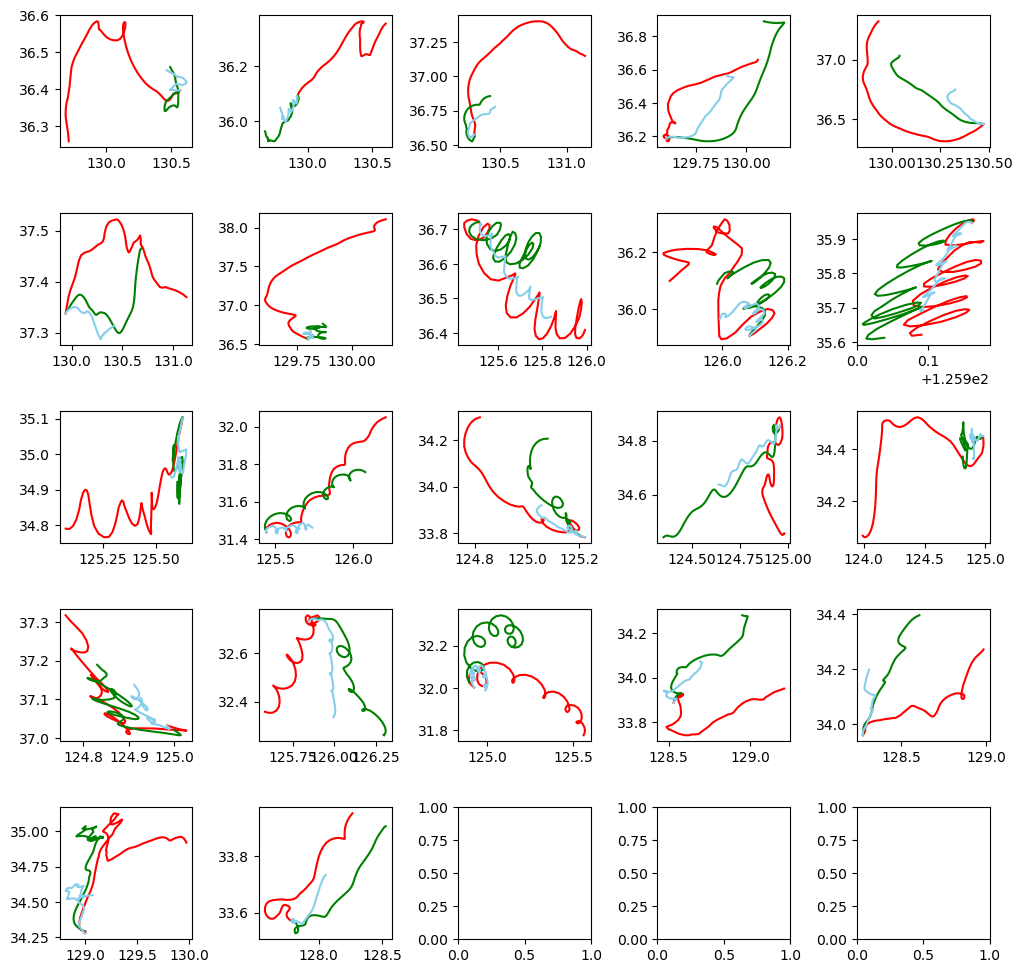

In [7]:
# 30
import lightgbm as lgb 
import random
seed = 42
tf.keras.utils.set_random_seed(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
baseline_MAE_list = list() 
baseline_NCLS_list = list()
MAE_list = list()
NCLS_list = list()
test_case_list = list()

for i in range(len(dataset)):
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    AE_X = train[0][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff_lon', 'diff_lat','diff']]
    train_X = train[0][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    AE_X = AE_X[1:]
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        add = train[j][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff_lon', 'diff_lat','diff']]
        trina_xi = train[j][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        add = add[1:]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        AE_X = pd.concat([AE_X,add],ignore_index = True)
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        add =  only_train_dataset[k][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff_lon', 'diff_lat','diff']]
        trina_xi = only_train_dataset[k][['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        add = add[1:]
        
        AE_X = pd.concat([AE_X,add],ignore_index = True)
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    test = dataset[i]
    start_lon = dataset[i]['start_lon'][0]
    start_lat = dataset[i]['start_lat'][0]
    test_X = test[['wind_x', 'water_velocity_x', 'wind_y', 'water_velocity_y','diff_mod']]
    test_X = test_X[1:]
    test_X = test_X.reset_index(drop = True)
    diff_mod = test_X['diff_mod'][0]
    test_X['diff_mod'] = 0
    test_X['diff_mod'][0] = diff_mod 
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    
    latent_dim = 30
    AE_X = AE_X.to_numpy()
    autoencoder = Autoencoder(latent_dim)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(AE_X,AE_X,
                    epochs=150,
                    shuffle=True)
    encoded = autoencoder.encoder(AE_X).numpy()
    decoded = autoencoder.decoder(encoded).numpy()
    add_X = decoded[:,[0,1,2,3,6]]
    add_y = decoded[:,[4,5]]
    
    train_X = np.concatenate((train_X.to_numpy(),add_X), axis = 0)
    
    train_y = np.concatenate((train_y,add_y), axis = 0)
    
    
    # 행단위로 살펴보기
    test_case_df = dataset[i][['time', 'obs_x1_lon', 'obs_x1_lat', 'wind_y','wind_x','water_velocity_y','water_velocity_x','model_x2_lon', 'model_x2_lat']]
    test_case_df['rf_lon'] = start_lon
    test_case_df['rf_lat'] = start_lat
    test_case_df['ncls_model'] = 0
    test_case_df['ncls_rf'] = 0
    
    # lightgbm 모델 생성
    lightgb_lon = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.009, n_estimators=270,max_depth=4
                              )
    lightgb_lat = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.009, n_estimators=270,max_depth=4
                            )
    
    # lightgbm 모델 훈련
    lightgb_lon.fit(train_X, train_y[:,0])
    lightgb_lat.fit(train_X, train_y[:,1])

    # Predict
    y_pred = np.zeros((len(test_X),2))
    pred_lon = lightgb_lon.predict(test_X.loc[[0],:])
    pred_lat = lightgb_lat.predict(test_X.loc[[0],:])
    y_pred[0][0] = pred_lon
    y_pred[0][1] = pred_lat
    
    for k in range(1,len(test_X)):
        diff = (y_pred[k-1][0]**2 + y_pred[k-1][1]**2)**(1/2)
        test_X['diff_mod'][k] = diff
        pred_lon = lightgb_lon.predict(test_X.loc[[k],:])
        pred_lat = lightgb_lat.predict(test_X.loc[[k],:])
        y_pred[k][0] = pred_lon
        y_pred[k][1] = pred_lat
    # case 별로 이상행 탐색
    for k in range(1,len(test_case_df)-1):
        test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
        test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
        test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
        test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
    
    test_case_df['rf_diff_lon'] = test_case_df['rf_lon'].diff()
    test_case_df['rf_diff_lon'][0] = 0
    test_case_df['rf_diff_lat'] = test_case_df['rf_lat'].diff()  
    test_case_df['rf_diff_lat'][0] = 0
    test_case_df['model_diff_lon'] = test_case_df['model_x2_lon'].diff() 
    test_case_df['model_diff_lon'][0] = 0
    test_case_df['model_diff_lat'] = test_case_df['model_x2_lat'].diff()
    test_case_df['model_diff_lat'][0] = 0
    test_case_list.append(test_case_df)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    baseline_pred = np.concatenate((baseline_lon.reshape((baseline_lon.shape[0],1)), baseline_lat.reshape((baseline_lat.shape[0],1))),axis =1)
    
    #mae
    MAE_list.append(drift_mae(y, pred))
    baseline_MAE_list.append(drift_mae(y, baseline_pred))
    
    #NCLS
    NCLS_list.append(NCLS_score(y, pred))
    baseline_NCLS_list.append(NCLS_score(y, baseline_pred))
    
    for i in range(len(MAE_list)):
        print('------------------------ Model ', i+1, '------------------------')
        print('baseline',str(i),' MAE : ',MAE_list[i])
        print('Model',str(i),' MAE : ', baseline_MAE_list[i])
        print('baseline',str(i),' NCLS : ',baseline_NCLS_list[i])
        print('Model',str(i),' NCLS : ', NCLS_list[i])

plt.show()

In [8]:
# lightgbm # 에포크 처리
mae_sum = 0
baseline_mae_sum = 0
NCLS_sum = 0
baseline_NCLS_sum = 0

for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    baseline_mae_sum += baseline_MAE_list[i]
    NCLS_sum += NCLS_list[i]
    baseline_NCLS_sum += baseline_NCLS_list[i]

# 라이브러리 Mae    
print ('Model Mae : ', mae_sum/len(dataset) )
print ('Baseline Mae : ', baseline_mae_sum/len(dataset) )
print ('Model NCLS : ', NCLS_sum/len(dataset) )
print ('Baseline NCLS : ', baseline_NCLS_sum/len(dataset) )

Model Mae :  0.1920205025781228
Baseline Mae :  0.18057603746811715
Model NCLS :  0.5234873794079563
Baseline NCLS :  0.5326670971119444
